In [1]:
#### ALL NOTEBOOK SHOULD HAVE SOME VERSION OF THIS #####################################
########################################################################################
%load_ext autoreload
%autoreload 2
import os
import sys

currentdir = os.getcwd()
# go to root directory. change the # of os.path.dirnames based on where currentdir is
parentdir = os.path.dirname(os.path.dirname(currentdir)) 
# chek where I'm at. if I go too far up the tree, go back
if 'Protein-Purification-Model-Public' not in parentdir: parentdir = currentdir
if parentdir not in sys.path: sys.path.insert(0,parentdir)
########################################################################################

In [2]:
import utils
import visualization.simple_data_vis as vis
import surrogate_models.dab_nn_defs as engine
import kerastuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# load data from just-private/data
filename = 'mol_res_scan_results_7.csv'
data = utils.load_data(parentdir, filename)

# since currently data is just one big dataframe, select model inputs as X and purity, yield as Y
x = [*data.columns[:2],*data.columns[4:]]
y = data.columns[2:4]

In [7]:
CV = 5
data2split, validation = utils.chroma_train_test_split(data, test_size=0.20)
trains, tests = utils.data_pipeline([data2split,], x, y, cv = CV)

In [10]:
models = []
for i in range(CV):
    dlr = engine.create_deterministic_linear_regressor(
        FEATURE_NAMES = x,
        TARGET_NAMES = y,
        name = 'DLR_'+str(i)+'_'+filename[:-4]
    )

    pnn = engine.create_probabilistic_nn(
        FEATURE_NAMES = x,
        TARGET_NAMES = y,
        hidden_units = [16,8,4,],
        name = 'PNN_'+str(i)+'_'+filename[:-4],
    )

    models.append([dlr, pnn])

In [11]:
dlr.summary()

Model: "DLR_4_mol_res_scan_results_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 18)]         0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 1)            19          input[0][0]                      
__________________________________________________________________________________________________
yield (Dense)                   (None, 1)            2           dense_20[0][0]                   
__________________________________________________________________________________________________
purity (Dense)                  (None, 1)            2           dense_20[0][0]                   
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________

In [16]:
# train all the models under the same conditions
learning_rate = 0.01
epochs = 100
optimizer = 'Adam' # change manually or come up with dictionary?
losses = ['mean_squared_error', engine.negative_loglikelihood]*2
loss_weights = (1/trains[0][0][1].mean().div(trains[0][0][1].mean().max())).round(2).to_dict()
histories = {}

for i in range(CV):
    print('CV round '+str(i))
    for m,l in zip(models[i], losses):
        histories[utils.get_model_name(m,filename)] = engine.run_experiment(
            model = m, 
            loss = {y[0]:l,y[1]:l},
            loss_weights = loss_weights,
            optimizer = tf.keras.optimizers.Adam,
            learning_rate = learning_rate,
            num_epochs = epochs,
            train_dataset = trains[0][i], 
            test_dataset = tests[0][i],
            verbose = 0,
            log = 0
            )

settings = {'learning_rate' : learning_rate,
            'epochs' : epochs,
            'optimizer': optimizer,
            'loss_weights': loss_weights,
            'dataset' : filename}

Start training the model DLR_0_mol_res_scan_results_7 ...


KeyboardInterrupt: 

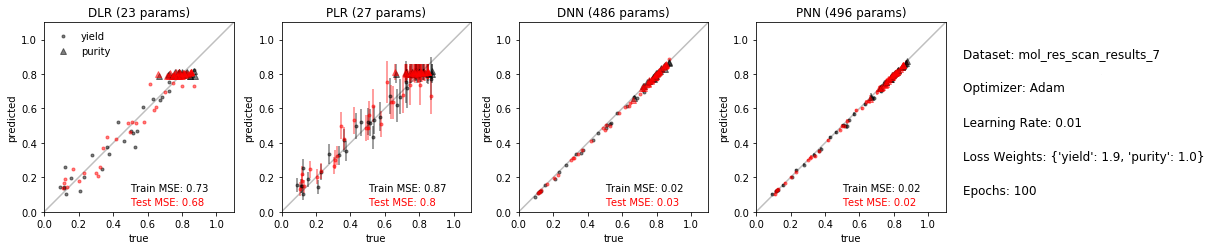

In [12]:
# check model predictions
vis.scatter_hats(models, train, test, settings, N = 25)